In [1]:
import numpy as np
from skimage import io


class ImageParser:
    def __init__(self):
        pass

    @staticmethod
    def read_png(path):
        image = io.imread(path, as_gray=True)
        return np.add(image < 0.4, image < 0.8, dtype=int)

    @staticmethod
    def write_png(image, path):
        fib = [153, 1, 2]
        myo = [226, 168, 88]

        out_image = np.zeros((image.shape[0], image.shape[1], 3),
                             dtype=np.uint8)
        out_image[image == 1] = myo
        out_image[image == 2] = fib
        io.imsave(path, out_image)

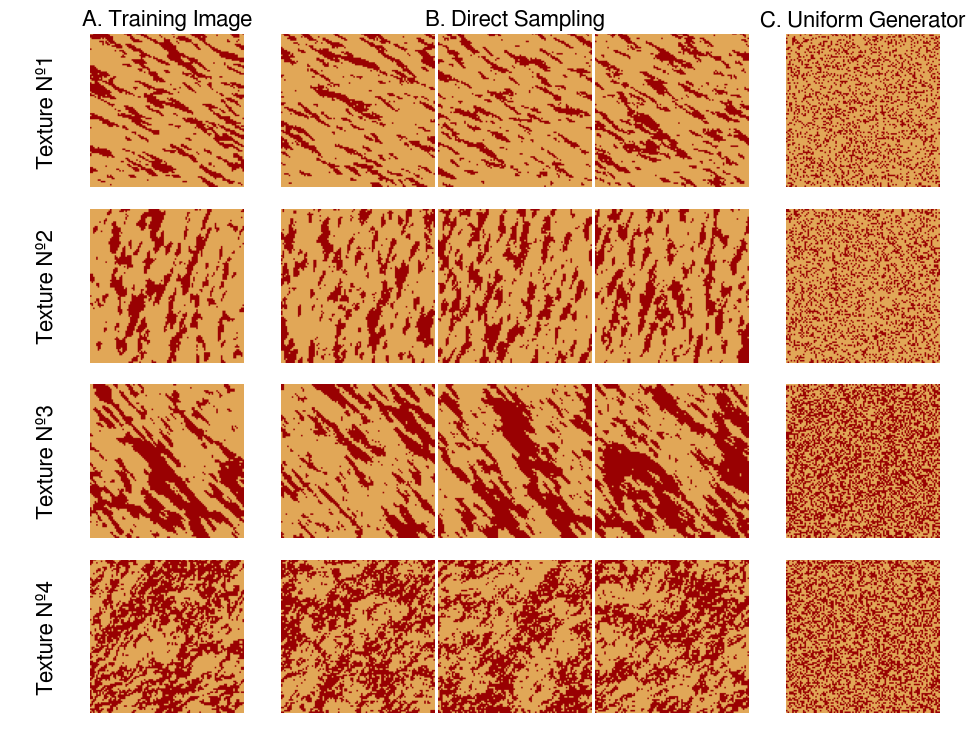

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# plt.rcParams['font.family'] = 'Helvetica'
plt.rc('font', family='FreeSans')


tex_cmap = mcolors.LinearSegmentedColormap.from_list(
    'fibrosis', [(0, '#e2a858'),
                 (0.5, '#e2a858'),
                 (1, '#990102')])

# path = Path('/Users/arstanbek/Projects/BiTis/data')
path = Path('/home/arstan/Projects/Fibrosis/BiTis/data')

pattern_ids = [25, 2, 34, 5]

fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(12, 9),
                        width_ratios=[0.5, 1, 0.2, 1, 1, 1, 0.2, 1],
                        gridspec_kw={'hspace': 0.05, 'wspace': 0.03})
for ax in axs.flatten():
    ax.axis('off')

for i, pattern_id in enumerate(pattern_ids):
    tr_filename = f'or_tex_{pattern_id}.png'
    tr_image = ImageParser.read_png(path.joinpath('training', tr_filename))
    tr_image = tr_image[:100, :100]
    tr_image[tr_image == 0] = 1

    axs[i, 1].imshow(tr_image.T, vmin=0, vmax=2, cmap=tex_cmap, origin='lower',
                     aspect='equal')

    img = []
    dens = []
    inds = np.random.choice(np.arange(100), 3, replace=False)

    for idx in inds:
        image = ImageParser.read_png(path.joinpath(f'simulated_{pattern_id}',
                                                   f'gen_tex_{pattern_id}_{idx}.png'))
        img.append(image[:100, :100])
        dens.append(np.mean(image == 2))
    
    uni_img = 1 + (np.random.random(img[-1].shape) <= dens[-1]).astype(int)
    axs[i, -1].imshow(uni_img.T, vmin=0, vmax=2, cmap=tex_cmap, origin='lower')

    for ax_id, im in zip([3, 4, 5], img):
        ax = axs[i, ax_id]
        ax.imshow(im.T, vmin=0, vmax=2, cmap=tex_cmap, origin='lower')

axs[0, 1].set_title('A. Training Image', fontsize=16)
axs[0, 4].set_title('B. Direct Sampling', fontsize=16)
axs[0, -1].set_title('C. Uniform Generator', fontsize=16)

for i, text in enumerate(['Texture Nº1', 'Texture Nº2',
                          'Texture Nº3', 'Texture Nº4']):
    axs[i, 0].text(0.5, 0.5, text, fontsize=16, ha='center', va='center',
                   transform=axs[i, 0].transAxes, rotation=90)

plt.show()

In [16]:
# path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
path_save = Path('/home/arstan/Projects/Fibrosis/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('ds_generation_images.png'),
            dpi=300, bbox_inches='tight')

## Generation Quality

In [5]:
import pandas as pd
from bitis.texture.texture import Texture
from bitis.texture.properties import (
    PatternPropertiesBuilder,
    DistributionEllipseBuilder,
    PolarPlots,
    PointDensity
)


def calc_props(image, area_min=10, area_quantile=0.95):
    pattern_builder = PatternPropertiesBuilder(area_quantile=area_quantile,
                                               area_min=area_min)
    pattern_props = pattern_builder.build(image == 2)
    return pattern_props, pattern_builder.object_props


def read_image(path):
    image = ImageParser.read_png(path)
    image[image == 0] = 1
    return image[:100, :100]


def make_pattern_stats(path, pattern_ids, n_samples=100):
    
    all_pattern_props = []
    all_object_props = []
    for pattern_id in pattern_ids:
        for i in range(n_samples):
            image = read_image(path.joinpath(f'simulated_{pattern_id}',
                                             f'gen_tex_{pattern_id}_{i}.png'))
            
            pattern_props, object_props = calc_props(image)
            pattern_props['pattern_id'] = pattern_id

            object_props['pattern_id'] = pattern_id
            object_props['sample_id'] = i

            all_pattern_props.append(pattern_props)
            all_object_props.append(object_props)
    
    all_pattern_props = pd.concat(all_pattern_props).reset_index(drop=True)
    all_object_props = pd.concat(all_object_props).reset_index(drop=True)
    return all_pattern_props, all_object_props



data, objects_data = make_pattern_stats(path, [25, 2, 34, 5])

In [6]:
data.loc[data['orientation'] < 0, 'orientation'] = np.pi + \
    data[data['orientation'] < 0]['orientation']
data.loc[data['orientation'] > np.pi/2, 'orientation'] = - \
    np.pi + data[data['orientation'] > np.pi/2]['orientation']

data['deg_orientation'] = np.degrees(data['orientation'])

data.groupby('pattern_id').describe().T

pattern_id                           2           5           25          34
density               count  100.000000  100.000000  100.000000  100.000000
                      mean     0.258667    0.418056    0.206165    0.383636
                      std      0.021066    0.029331    0.018304    0.050740
                      min      0.199800    0.334400    0.157400    0.269800
                      25%      0.243350    0.399475    0.194875    0.347850
                      50%      0.259300    0.420350    0.203850    0.381900
                      75%      0.276025    0.437675    0.217125    0.423600
                      max      0.300300    0.507800    0.259200    0.489200
elongation            count  100.000000  100.000000  100.000000  100.000000
                      mean     2.641107    2.006752    3.949987    3.067594
                      std      0.296243    0.188804    0.352819    0.414315
                      min      2.145134    1.573246    3.185687    2.153236
                      25%      2.448839    1.867941    3.682025    2.796243
                      50%      2.607216    2.004942    3.958161    3.075552
                      75%      2.836802    2.112864    4.160073    3.316002
                      max      3.508849    2.525920    4.724516    4.345089
orientation           count  100.000000  100.000000  100.000000  100.000000
                      mean     1.378821    0.749873   -0.472135   -0.835567
                      std      0.055863    0.185481    0.042672    0.065490
                      min      1.246001    0.337471   -0.575584   -1.116956
                      25%      1.344825    0.663671   -0.505482   -0.869387
                      50%      1.377810    0.750314   -0.472208   -0.830170
                      75%      1.413021    0.853721   -0.442365   -0.802639
                      max      1.503077    1.326410   -0.373897   -0.686923
compactness           count  100.000000  100.000000  100.000000  100.000000
                      mean     0.134499    0.345428    0.098531    0.323630
                      std      0.021268    0.039473    0.016058    0.057726
                      min      0.083500    0.238400    0.063800    0.200400
                      25%      0.120550    0.324425    0.085725    0.275475
                      50%      0.132250    0.343000    0.095100    0.328400
                      75%      0.148925    0.370875    0.111175    0.363775
                      max      0.190700    0.473100    0.135900    0.442400
structural_anisotropy count  100.000000  100.000000  100.000000  100.000000
                      mean     5.591070    2.387088    9.298151    8.327516
                      std      1.415560    0.816452    2.155431    3.513101
                      min      3.159808    1.398742    5.880090    3.427297
                      25%      4.737883    1.922686    7.643855    6.129306
                      50%      5.269584    2.174618    9.114660    7.745605
                      75%      6.436612    2.558771   10.571952    9.462125
                      max     11.356534    6.536841   15.124142   18.926340
solidity              count  100.000000  100.000000  100.000000  100.000000
                      mean     0.746744    0.655399    0.720724    0.737614
                      std      0.018095    0.022836    0.016641    0.025200
                      min      0.681616    0.586260    0.662498    0.669952
                      25%      0.735852    0.642789    0.712150    0.719866
                      50%      0.745172    0.655773    0.720308    0.736893
                      75%      0.759612    0.669069    0.732085    0.758198
                      max      0.780444    0.710129    0.762781    0.798484
deg_orientation       count  100.000000  100.000000  100.000000  100.000000
                      mean    79.000650   42.964542  -27.051341  -47.874456
                      std      3.200687   10.627264    2.444949    3.752306
                      min     71.390600   19.335

In [7]:
# path = Path('/Users/arstanbek/Projects/BiTis/data/training')

tr_props = []
tr_objects = []

for pattern_id in pattern_ids:
    tr_image = read_image(path.joinpath('training', 
                                        f'or_tex_{pattern_id}.png'))
    pprops, oprops = calc_props(tr_image)
    pprops['pattern_id'] = pattern_id

    oprops['pattern_id'] = pattern_id
    oprops['sample_id'] = 0

    tr_props.append(pprops)
    tr_objects.append(oprops)

tr_data = pd.concat(tr_props).reset_index(drop=True)
tr_objects = pd.concat(tr_objects).reset_index(drop=True)
tr_data.loc[tr_data['orientation'] > 0.5 * np.pi, 'orientation'] -= np.pi

In [8]:
tr_data['deg_orientation'] = np.degrees(tr_data['orientation'])
tr_data.groupby('pattern_id').describe().T

pattern_id                          2          5          25         34
density               count   1.000000   1.000000   1.000000   1.000000
                      mean    0.235700   0.452000   0.251000   0.360300
                      std          NaN        NaN        NaN        NaN
                      min     0.235700   0.452000   0.251000   0.360300
                      25%     0.235700   0.452000   0.251000   0.360300
                      50%     0.235700   0.452000   0.251000   0.360300
                      75%     0.235700   0.452000   0.251000   0.360300
                      max     0.235700   0.452000   0.251000   0.360300
elongation            count   1.000000   1.000000   1.000000   1.000000
                      mean    2.629175   1.793300   4.342572   3.909836
                      std          NaN        NaN        NaN        NaN
                      min     2.629175   1.793300   4.342572   3.909836
                      25%     2.629175   1.793300   4.342572   3.909836
                      50%     2.629175   1.793300   4.342572   3.909836
                      75%     2.629175   1.793300   4.342572   3.909836
                      max     2.629175   1.793300   4.342572   3.909836
orientation           count   1.000000   1.000000   1.000000   1.000000
                      mean    1.331358   0.872939  -0.485330  -0.854912
                      std          NaN        NaN        NaN        NaN
                      min     1.331358   0.872939  -0.485330  -0.854912
                      25%     1.331358   0.872939  -0.485330  -0.854912
                      50%     1.331358   0.872939  -0.485330  -0.854912
                      75%     1.331358   0.872939  -0.485330  -0.854912
                      max     1.331358   0.872939  -0.485330  -0.854912
compactness           count   1.000000   1.000000   1.000000   1.000000
                      mean    0.113800   0.391400   0.126600   0.305100
                      std          NaN        NaN        NaN        NaN
                      min     0.113800   0.391400   0.126600   0.305100
                      25%     0.113800   0.391400   0.126600   0.305100
                      50%     0.113800   0.391400   0.126600   0.305100
                      75%     0.113800   0.391400   0.126600   0.305100
                      max     0.113800   0.391400   0.126600   0.305100
structural_anisotropy count   1.000000   1.000000   1.000000   1.000000
                      mean    4.413714   3.443814  11.705225  10.879331
                      std          NaN        NaN        NaN        NaN
                      min     4.413714   3.443814  11.705225  10.879331
                      25%     4.413714   3.443814  11.705225  10.879331
                      50%     4.413714   3.443814  11.705225  10.879331
                      75%     4.413714   3.443814  11.705225  10.879331
                      max     4.413714   3.443814  11.705225  10.879331
solidity              count   1.000000   1.000000   1.000000   1.000000
                      mean    0.754208   0.643644   0.704510   0.731105
                      std          NaN        NaN        NaN        NaN
                      min     0.754208   0.643644   0.704510   0.731105
                      25%     0.754208   0.643644   0.704510   0.731105
                      50%     0.754208   0.643644   0.704510   0.731105
                      75%     0.754208   0.643644   0.704510   0.731105
                      max     0.754208   0.643644   0.704510   0.731105
deg_orientation       count   1.000000   1.000000   1.000000   1.000000
                      mean   76.281196  50.015721 -27.807371 -48.982871
                      std          NaN        NaN        NaN        NaN
                      min    76.281196  50.015721 -27.807371 -48.982871
                      25%    76.281196  50.015721 -27.807371 -48.982871
                      50%    76.281196  50.015721 -27.807371 -48.982871
                      75%    76.281196  

In [9]:
uni_props = []
uni_objects = []

for pattern_id in pattern_ids:
    uni_image = read_image(path.joinpath('training', 
                                        f'or_tex_{pattern_id}.png'))
    dens = np.mean(uni_image == 2)
    uni_image = 1 + (np.random.random(uni_image.shape) <= dens).astype(int)
    pprops, oprops = calc_props(uni_image)
    pprops['pattern_id'] = pattern_id

    oprops['pattern_id'] = pattern_id
    oprops['sample_id'] = 0

    uni_props.append(pprops)
    uni_objects.append(oprops)

uni_data = pd.concat(uni_props).reset_index(drop=True)
uni_objects = pd.concat(uni_objects).reset_index(drop=True)
uni_data.loc[uni_data['orientation'] > 0.5 * np.pi, 'orientation'] -= np.pi

/home/arstan/Projects/Fibrosis/BiTis/bitis/texture/properties/distribution_ellipse.py:58: UserWarning: Not enough points to build the distribution ellipse.
  warnings.warn('Not enough points to build the distribution ellipse.')


In [10]:
uni_data['deg_orientation'] = 0
uni_data['orientation'] = 0
uni_data.groupby('pattern_id').describe().T

pattern_id                         2         5         25        34
density               count  1.000000  1.000000  1.000000  1.000000
                      mean   0.240300  0.455100  0.258200  0.364100
                      std         NaN       NaN       NaN       NaN
                      min    0.240300  0.455100  0.258200  0.364100
                      25%    0.240300  0.455100  0.258200  0.364100
                      50%    0.240300  0.455100  0.258200  0.364100
                      75%    0.240300  0.455100  0.258200  0.364100
                      max    0.240300  0.455100  0.258200  0.364100
elongation            count  1.000000  1.000000  1.000000  1.000000
                      mean   2.696693  1.917485  2.171615  2.007152
                      std         NaN       NaN       NaN       NaN
                      min    2.696693  1.917485  2.171615  2.007152
                      25%    2.696693  1.917485  2.171615  2.007152
                      50%    2.696693  1.917485  2.171615  2.007152
                      75%    2.696693  1.917485  2.171615  2.007152
                      max    2.696693  1.917485  2.171615  2.007152
orientation           count  1.000000  1.000000  1.000000  1.000000
                      mean   0.000000  0.000000  0.000000  0.000000
                      std         NaN       NaN       NaN       NaN
                      min    0.000000  0.000000  0.000000  0.000000
                      25%    0.000000  0.000000  0.000000  0.000000
                      50%    0.000000  0.000000  0.000000  0.000000
                      75%    0.000000  0.000000  0.000000  0.000000
                      max    0.000000  0.000000  0.000000  0.000000
compactness           count  1.000000  1.000000  1.000000  1.000000
                      mean   0.043900  0.176900  0.052800  0.091000
                      std         NaN       NaN       NaN       NaN
                      min    0.043900  0.176900  0.052800  0.091000
                      25%    0.043900  0.176900  0.052800  0.091000
                      50%    0.043900  0.176900  0.052800  0.091000
                      75%    0.043900  0.176900  0.052800  0.091000
                      max    0.043900  0.176900  0.052800  0.091000
structural_anisotropy count  0.000000  1.000000  1.000000  1.000000
                      mean        NaN  1.057589  2.789873  1.677570
                      std         NaN       NaN       NaN       NaN
                      min         NaN  1.057589  2.789873  1.677570
                      25%         NaN  1.057589  2.789873  1.677570
                      50%         NaN  1.057589  2.789873  1.677570
                      75%         NaN  1.057589  2.789873  1.677570
                      max         NaN  1.057589  2.789873  1.677570
solidity              count  1.000000  1.000000  1.000000  1.000000
                      mean   0.796922  0.653181  0.700128  0.673373
                      std         NaN       NaN       NaN       NaN
                      min    0.796922  0.653181  0.700128  0.673373
                      25%    0.796922  0.653181  0.700128  0.673373
                      50%    0.796922  0.653181  0.700128  0.673373
                      75%    0.796922  0.653181  0.700128  0.673373
                      max    0.796922  0.653181  0.700128  0.673373
deg_orientation       count  1.000000  1.000000  1.000000  1.000000
                      mean   0.000000  0.000000  0.000000  0.000000
                      std         NaN       NaN       NaN       NaN
                      min    0.000000  0.000000  0.000000  0.000000
                      25%    0.000000  0.000000  0.000000  0.000000
                      50%    0.000000  0.000000  0.000000  0.000000
                      75%    0.000000  0.000000  0.000000  0.000000
                      max    0.000000  0.000000  0.000000  0.000000

In [40]:
def calc_ccdf(df):
    count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    ccdf = np.cumsum(count[::-1])[::-1] / np.sum(count)
    return area_bins, ccdf


def calc_area_cdf(df):
    count = np.bincount(df['area'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]
    area = area_bins * count

    cdf = np.cumsum(area) / np.sum(area)
    return area_bins, cdf


def draw_area_cdf(ax, objects_props, label='', color='blue', alpha=1.0):
    area_bins, cdf = calc_area_cdf(objects_props)
    ax.plot(area_bins, cdf, label=label, color=color, alpha=alpha)
    ax.set_xlabel('Cluster Size', fontsize=16)
    ax.set_ylabel('Fibrotic Tissue', fontsize=16)
    ax.set_xscale('log')


def draw_ccdf(ax, objects_props, label='', color='blue', alpha=1.0, title=''):
    area_bins, ccdf = calc_ccdf(objects_props)
    ax.plot(area_bins, ccdf, label=label, color=color, alpha=alpha)
    ax.set_xlabel('Cluster Size', fontsize=16)
    # ax.set_ylabel('CCDF')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(True, which='both', alpha=0.5)
    ax.set_title(title, fontsize=16, loc='left')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_3555/1238751698.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_3555/1238751698.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_3555/1238751698.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_3555/1238751698.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedL

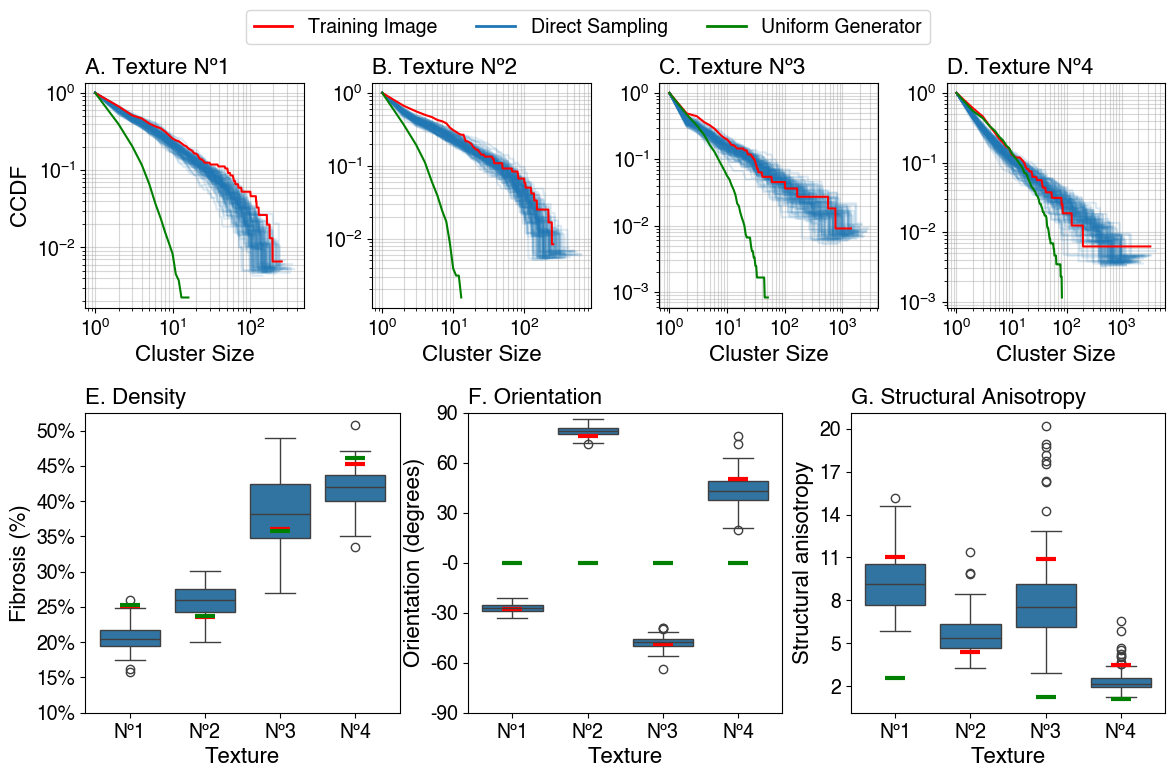

In [41]:
import seaborn as sns
import matplotlib as mpl


data.loc[data['orientation'] < 0, 'orientation'] = np.pi + \
    data[data['orientation'] < 0]['orientation']
data.loc[data['orientation'] > np.pi/2, 'orientation'] = - \
    np.pi + data[data['orientation'] > np.pi/2]['orientation']

# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']
colors = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue']
axs_ids = ['a', 'b', 'c', 'd', 'e', 'f', 'g']
titles = ['A. Texture Nº1', 'B. Texture Nº2', 'C. Texture Nº3', 'D. Texture Nº4',
          'E. Density', 'F. Orientation', 'G. Structural Anisotropy']

fig, axs = plt.subplot_mosaic([['a', 'a', 'a',
                                'b', 'b', 'b',
                                'c', 'c', 'c',
                                'd', 'd', 'd'],
                               ['e', 'e', 'e', 'e',
                                'f', 'f', 'f', 'f',
                                'g', 'g', 'g', 'g'],
                               ], 
                                figsize=(12, 7.5),
                                height_ratios=[3, 4])

for i, prop in enumerate(['density', 'orientation', 'structural_anisotropy']):
    sns.boxplot(x='pattern_id', y=prop, data=data, order=pattern_ids, ax=axs[axs_ids[i+4]],
                palette=colors, linewidth=1, hue='pattern_id', legend=False)
    axs[axs_ids[i+4]].plot(tr_data[prop], marker='_', markersize=15, markeredgewidth=3,
                ls='', color='r', label='Training Image')
    axs[axs_ids[i+4]].plot(uni_data[prop], marker='_', markersize=15, markeredgewidth=3,
                ls='', color='g', label='Uniform Generator')
    axs[axs_ids[i+4]].set_xticks(np.arange(len(pattern_ids)))
    axs[axs_ids[i+4]].set_xticklabels([f'Nº{i}' for i in range(1, 1 + len(pattern_ids))],
                           fontsize=14)
    axs[axs_ids[i+4]].set_xlabel('Texture', fontsize=16)
    axs[axs_ids[i+4]].set_title(titles[i + 4], fontsize=16, loc='left')

legend_lines = [mpl.lines.Line2D([0], [0], color='red', lw=2, label='Training Image'),
                mpl.lines.Line2D([0], [0], color='tab:blue', lw=2, label='Direct Sampling'),
                mpl.lines.Line2D([0], [0], color='g', lw=2, label='Uniform Generator')]

# for subplot in ['a', 'b', 'c', 'd']:
#     axs[subplot].legend(handles=legend_lines, loc='lower left', fontsize=11)

# axs['e'].legend(handles=legend_lines, loc='upper left', fontsize=11)
# axs['f'].legend(handles=legend_lines, loc='lower left', fontsize=11)
# axs['g'].legend(handles=legend_lines, loc='upper left', fontsize=11)

axs['e'].set_yticks(np.arange(0.1, 0.55, 0.05))
axs['e'].set_yticklabels(axs['e'].get_yticks(), fontsize=14)
axs['e'].set_ylabel('Fibrosis (%)', fontsize=16)
axs['e'].yaxis.set_major_formatter(
    mpl.ticker.PercentFormatter(xmax=1, decimals=0))

axs['f'].set_ylim(-np.pi/2, np.pi/2)
axs['f'].set_yticks(np.arange(-np.pi/2, 1.1 * np.pi/2, np.pi/6))
axs['f'].set_yticklabels(axs['f'].get_yticks(), fontsize=14)
axs['f'].set_ylabel('Orientation (degrees)', fontsize=16)
axs['f'].yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, _: f'{np.rad2deg(x):.0f}'))

axs['g'].set_yticks(np.arange(2, 21, 3))
axs['g'].set_yticklabels(axs['g'].get_yticks(), fontsize=14)
axs['g'].set_ylabel('Structural anisotropy', fontsize=16)
axs['g'].yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, _: f'{x:.0f}'))

for i, pattern_id in enumerate(pattern_ids):
    for j in range(100):
        draw_ccdf(axs[axs_ids[i]], objects_data[(objects_data['pattern_id'] == pattern_id) &
                                            (objects_data['sample_id'] == j)],
                                            color=colors[i], alpha=0.15)
    draw_ccdf(axs[axs_ids[i]], tr_objects[tr_objects['pattern_id'] == pattern_id],
              label='Training Image', color='red', alpha=1.0, title=titles[i])
    draw_ccdf(axs[axs_ids[i]], uni_objects[uni_objects['pattern_id'] == pattern_id],
              label='Uniform Generator', color='g', alpha=1.0, title=titles[i])
    # axs[axs_ids[i]].legend(loc='lower right', fontsize=11)
axs['a'].set_ylabel('CCDF', fontsize=16)

# plt.tight_layout()

fig.legend(handles=legend_lines,
           loc='upper center', ncol=3, prop={'size': 14})

plt.subplots_adjust(top=0.89, 
                    bottom=0.05, 
                    left=0.05, 
                    right=0.95, 
                    hspace=0.4,
                    wspace=2.5)
plt.show()

In [42]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('ds_generation_quality.png'),
            dpi=300, bbox_inches='tight')